# Bias Reduction

Climate models can have biases towards different references. Commonly, biases are reduced by postprocessing before verification of forecasting skill. `climpred` provides convenience functions to do so.

In [54]:
import climpred
import xarray as xr
import matplotlib.pyplot as plt
from climpred import HindcastEnsemble
hind = climpred.tutorial.load_dataset('CESM-DP-SST') # CESM-DPLE hindcast ensemble output.
# obs = climpred.tutorial.load_dataset('ERSST') # ERSST observations.
recon = climpred.tutorial.load_dataset('FOSI-SST') # Reconstruction simulation that initialized CESM-DPLE.
hind["lead"].attrs["units"] = "years"
v='SST'
alignment='same_verif'

In [55]:
# make obs/recon an anomaly 
# obs = obs - obs.sel(time=slice('1964', '2014')).mean('time')
recon = recon - recon.sel(time=slice('1964', '2014')).mean('time')

/Users/aaron.spring/Coding/climpred/climpred/utils.py:141: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  "Assuming annual resolution due to numeric inits. "


<AxesSubplot:xlabel='time', ylabel='SST'>

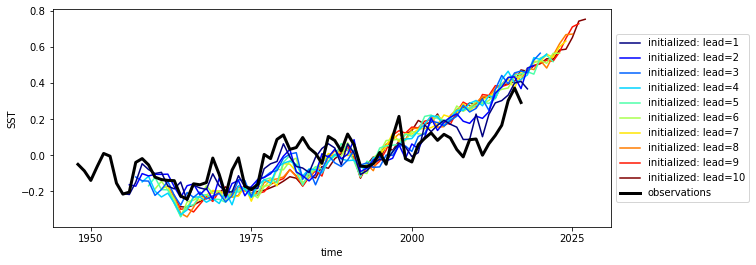

In [56]:
hindcast = HindcastEnsemble(hind)
# choose one observation
hindcast = hindcast.add_observations(recon)
# hindcast = hindcast.add_observations(obs) # fits hind better than reconstruction

hindcast.plot()

The warming of the `reconstruction` is less than the `initialized`.

## Mean bias reduction

Typically, bias depends on lead-time and therefore should therefore also be removed depending on lead-time.

In [57]:
# build bias_metric by hand
from climpred.metrics import Metric
def bias_func(a,b,**kwargs):
    return a-b
bias_metric = Metric('bias', bias_func, True, False,1)

In [58]:
bias = hindcast.verify(metric=bias_metric, comparison='e2r', dim='init', alignment=alignment).squeeze()

In [59]:
# equals using the pre-defined (unconditional) bias metric applied to over dimension member
xr.testing.assert_allclose(bias, hindcast.verify(metric='unconditional_bias', comparison='m2r',dim='member', alignment=alignment).squeeze())

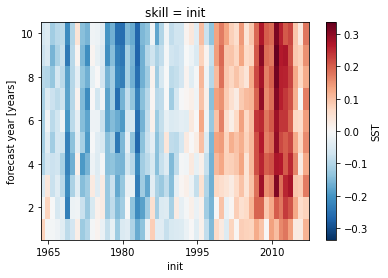

In [60]:
bias[v].plot()

- against `reconstruction`: Cold bias in early years and warm bias in later years.

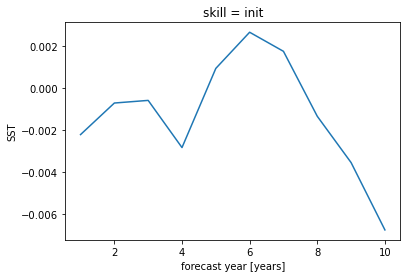

In [61]:
# lead-time dependant mean bias over all initializations is quite small
mean_bias = bias.mean('init')
mean_bias[v].plot()

### cross validatation
To remove the mean bias quickly, the mean bias over all initializations is subtracted, see `_mean_bias_reduction_quick`. For formally correct bias reduction with cross validation, the given initialization is left out when subtracting the mean bias, see `_mean_bias_reduction_cross_validate`.

In [62]:
from climpred.bias_reduction import _mean_bias_reduction_quick, _mean_bias_reduction_cross_validate
#_mean_bias_reduction_quick??
#_mean_bias_reduction_cross_validate??

`climpred` wraps these functions in `HindcastEnsemble.reduce_bias(how='mean', cross_validate={bool})`.

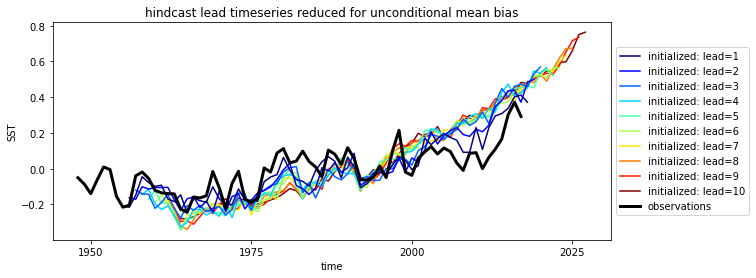

In [63]:
hindcast.reduce_bias(how='mean', cross_validate=True, alignment=alignment).plot()
plt.title('hindcast lead timeseries reduced for unconditional mean bias')
plt.show()

## Skill

Distance-based accuracy metrics like (`mse`,`rmse`,`nrmse`,...) are sensitive to mean bias reduction. Correlations like (`pearson_r`, `spearman_r`) are insensitive to bias correction.

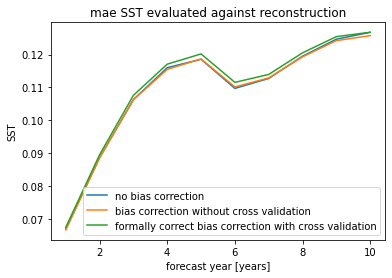

In [69]:
metric='mae'
hindcast.verify(metric=metric, comparison='e2o', dim='init', alignment=alignment)[v].plot(label='no bias correction')
hindcast.reduce_bias(cross_validate=False, alignment=alignment).verify(metric=metric, comparison='e2o', dim='init', alignment=alignment)[v].plot(label='bias correction without cross validation')
hindcast.reduce_bias(cross_validate=True, alignment=alignment).verify(metric=metric, comparison='e2o', dim='init', alignment=alignment)[v].plot(label='formally correct bias correction with cross validation')
plt.legend()
plt.title(f"{metric} {v} evaluated against reconstruction")
plt.show()